# E-Flux2 (08302023 data + StrainDesign) 
The purpose of the notebook is to run flux balance analysis to find the set of genome scale fluxes that maximizes biomass production.<br><br>
The flux balance analysis results are then compared to reaction rates determined by 13C-metabolic flux analysis (13C-MFA). <br><br>
The results of this notebook will be compared to transcript constained genome scale model flux results via E-Flux2. <br><br>
This notebook looks at glucose, glycerol, acetate, and oleic acid as sole carbon sources. <br><br>
In all cases, parsimonious flux balance analysis (pFBA) was used to prevent degenerate solutions.


### Load imports

In [1]:
import cobra
import pandas as pd
import sys


source_dir = '../src'
sys.path.append(source_dir)

from get_gene_transcript_dictionary import get_gene_transcript_dictionary
from get_reaction_transcript_dictionary import get_reaction_transcript_dictionary

from get_pfba_gsm_df import get_pfba_gsm_df
from get_eflux2_gsm_df import get_eflux2_gsm_df

from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from add_transcript_values_to_13c_flux_df import add_transcript_values_to_13c_flux_df

from make_5_boxplot_grid import make_5_boxplot_grid

### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_2.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id  = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x164029840
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load transcriptomics data

In [4]:
transcriptomics_df = pd.read_csv("../data/transcriptomics/fpkm_counts.csv")
transcriptomics_df

,JGI_id,YALI0_id,glucose_1,glucose_2,glucose_3,glycerol_1,glycerol_2,glycerol_3,oleic_acid_1,oleic_acid_2,oleic_acid_3
0,jgi.p|Yarli1|64471,YALI0A00110g,4.88,2.64,3.23,1.21,1.11,3.61,6.77,13.32,7.67
1,jgi.p|Yarli1|64472,YALI0A00132g,1896.43,1845.77,1682.56,1234.99,1189.24,1120.35,864.64,1056.63,928.51
2,jgi.p|Yarli1|64473,YALI0A00154g,31.34,29.21,21.92,215.23,137.85,182.81,1867.59,2153.21,1958.68
3,jgi.p|Yarli1|64474,YALI0A00176g,3.67,3.85,3.15,3.07,1.74,2.09,4.13,2.43,4.34
4,jgi.p|Yarli1|64475,YALI0A00198g,0.00,0.17,0.00,0.00,0.50,1.29,1.55,0.81,1.75
...,...,...,...,...,...,...,...,...,...,...,...
6442,jgi.p|Yarli1|70913,YALI0F32043g,20.63,17.60,17.12,13.94,13.84,11.94,10.76,12.38,10.37
6443,jgi.p|Yarli1|70914,YALI0F32065g,192.58,151.54,270.76,206.89,262.66,280.82,310.55,384.22,313.24
6444,jgi.p|Yarli1|70915,YALI0F32131g,0.12,0.66,0.14,0.34,0.29,0.64,1.01,0.58,1.33
6445,jgi.p|Yarli1|70916,YALI0F32153g,26.16,27.73,28.77,39.22,36.95,39.18,26.98,22.05,23.58


### Make gene -> transcript dictionaries for each condition

In [5]:
glucose_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_1')
glucose_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_2')
glucose_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_3')

glycerol_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_1')
glycerol_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_2')
glycerol_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_3')

oleic_acid_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_1')
oleic_acid_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_2')
oleic_acid_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_3')

glycerol_1_gene_transcripts


{'': inf,
 'YALI0A00110g': 1.21,
 'YALI0A00132g': 1234.99,
 'YALI0A00154g': 215.23,
 'YALI0A00176g': 3.07,
 'YALI0A00198g': 0.0,
 'YALI0A00212g': 6.31,
 'YALI0A00264g': 431.05,
 'YALI0A00286g': 168.19,
 'YALI0A00330g': 36.85,
 'YALI0A00352g': 1262.91,
 'YALI0A00369g': 2.47,
 'YALI0A00374g': 1.58,
 'YALI0A00396g': 83.79,
 'YALI0A00418g': 6.61,
 'YALI0A00440g': 203.47,
 'YALI0A00506g': 45.01,
 'YALI0A00528g': 0.28,
 'YALI0A00550g': 4.35,
 'YALI0A00572g': 0.87,
 'YALI0A00594g': 465.39,
 'YALI0A00616g': 31.17,
 'YALI0A00638g': 55.68,
 'YALI0A00660g': 44.31,
 'YALI0A00682g': 0.45,
 'YALI0A00759g': 37.36,
 'YALI0A00781g': 50.04,
 'YALI0A00803g': 129.99,
 'YALI0A00825g': 13.48,
 'YALI0A00847g': 47.26,
 'YALI0A00869g': 1.04,
 'YALI0A00891g': 170.39,
 'YALI0A00913g': 57.17,
 'YALI0A00935g': 0.47,
 'YALI0A00957g': 14.66,
 'YALI0A00979g': 21.97,
 'YALI0A01001g': 70.77,
 'YALI0A01023g': 94.11,
 'YALI0A01045g': 86.39,
 'YALI0A01067g': 213.91,
 'YALI0A01089g': 35.88,
 'YALI0A01111g': 50.01,
 'YALI0A

### Make reaction -> transcript dictionaries for each condition

In [6]:
glucose_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_1_gene_transcripts)
glucose_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_2_gene_transcripts)
glucose_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_3_gene_transcripts)

glycerol_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_1_gene_transcripts)
glycerol_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_2_gene_transcripts)
glycerol_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_3_gene_transcripts)

oleic_acid_1_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_1_gene_transcripts)
oleic_acid_2_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_2_gene_transcripts)
oleic_acid_3_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_3_gene_transcripts)

glycerol_1_reaction_transcripts

{'13BGH': 34.44,
 '13BGHe': 34.44,
 'ASADi': 370.66,
 '2DDA7Ptm': inf,
 '2DHPtm': inf,
 '2OHPH_5tn': inf,
 '2OMPH_5tm': inf,
 '2OMPH_5tn': inf,
 'ASPKi': 119.52,
 '34HPPOR': inf,
 '34HPPt2m': inf,
 '34HPPt2p': inf,
 '13GS': 0.39,
 '3C4MOPtm': inf,
 '3DSPHR': 107.06,
 '3HAO': 146.15,
 'GLCS2': 414.87,
 'SBTD_D2': 120.96,
 '3OPHB_5tm': inf,
 '4ABUTNtm': inf,
 '4ABUTtm': inf,
 '4ABZtm': inf,
 '4H2OGLTtm': inf,
 '4H2OGLTtp': inf,
 '4HBZtm': inf,
 '4HPRO_LTtm': inf,
 '4HTHRS': 185.27,
 '5AOPt2': 4.85,
 '5AOPtm': inf,
 '5MTHFtm': inf,
 '6PGLter': inf,
 '8AONNt2': inf,
 'AABTN': inf,
 'AASAD1': 172.08,
 'TRE6PP': 62.900000000000006,
 'ABTA': 88.19,
 'ABTt': inf,
 'ABUTDm': 0.4,
 'ABUTt2': 30.14,
 'TRE6PS': 23.91,
 'ACACT1m': 123.59,
 'ACACT4p': 581.47,
 'ACACT5p': 581.47,
 'ACACT6p': 581.47,
 'ACACT7p': 581.47,
 'ACACT8p': 581.47,
 'ACACT9p': 581.47,
 'PC': 535.91,
 'ACGAM6PS': 246.5,
 'ACGAMPM': 58.53,
 'ACGKm': 198.65,
 'ACGSm': 45.92,
 'ACOTAim': 212.89,
 'AGPRim': 198.65,
 'ACOAH': 488.85

### Load 13C-MFA and pFBA data

In [7]:
# load glucose 13C MFA data from ../data/13c_mfa/INCA_model_08302023_GR.xlsx
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_08302023_GR.xlsx', sheet_name='GSM Format')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0000,2.201100e-11,100.0000,100.0000,0.0000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-12.29,5.856500e+00,-23.5032,-2.2969,21.2063,-151.6655,1.094870e+01,-165.8804,-1.3939,164.4865


# Glucose

### New E-Flux2 method

### Define how boxes and whiskers of pFBA and E-Flux2 are defined

In [24]:
# For FVA analysis, define two levels of biomass production as a fraction of the maximum biomass production
# box_biomass_fraction = 0.95
# whisker_biomass_fraction = 0.90
box_biomass_fraction = 0.85
whisker_biomass_fraction = 0.80

### Run pFBA for glucose

In [25]:
glucose_pfba_df, box_biomass_flux, whisker_biomass_flux = get_pfba_gsm_df(
  model=model, 
  substrate='glucose', 
  box_biomass_fraction=box_biomass_fraction, 
  whisker_biomass_fraction=whisker_biomass_fraction,
)

glucose_pfba_df.head()

Glucose uptake flux: -100.
Maximum biomass flux: 11.398166174414.
The number of active reactions in pFBA: 291.

Running FVA constraining the biomass to 85.0% of maximum using the constraint:
EX_glc_e = -100, biomass_C >= 9.6884412482519
The number of active reactions in 85.0% biomass FVA: 719

Running FVA constraining the biomass to 80.0% of maximum using the constraint:
EX_glc_e = -100, biomass_C >= 9.1185329395312
The number of active reactions in 80.0% biomass FVA: 719


,reaction_id,reaction_name,full_reaction,flux,85_LB,85_UB,80_LB,80_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-560.394053,-1000.000000,-284.071213,-1000.000000,-192.067024
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],341.609652,235.221651,601.964602,209.620378,688.123547
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],335.476108,-220.105388,975.886396,-289.510954,1000.000000
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,326.533474,205.275220,589.303053,164.964913,669.932285
421,EX_h2o_e,H2O exchange,h2o[e] <=>,325.265198,261.593634,440.509240,240.527086,478.879013


In [26]:
print(box_biomass_flux, whisker_biomass_flux)

9.6884412482519 9.1185329395312


### Add glucose pFBA data to the central reaction dataframe

In [27]:
# add the pFBA data to the central reaction dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glucose_pfba_df, 'glucose_pfba_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glucose_pfba_df, 'glucose', 'pfba')

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_ΔB,glucose_pfba_flux,glucose_pfba_95_LB,glucose_pfba_95_UB,glucose_pfba_90_LB,glucose_pfba_90_UB,glucose_pfba_85_LB,glucose_pfba_85_UB,glucose_pfba_80_LB,glucose_pfba_80_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,0.0,-6.745562,0.0,-13.491124,0.0,-20.236686,0.0,-26.560173,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,164.4865,35.574485,-57.432341,88.758672,-104.760281,89.350321,-148.7273,89.941969,-183.536684,90.533618


### Run E-Flux2 for glucose 1

In [28]:
import pandas as pd
import numpy as np
import straindesign as sd
from is_active_in_fva import is_active_in_fva

# this function returns a dataframe with rows for every GSM reaction
# each row has cols for reaction_id, reaction_name, full_reaction, flux, trans_LB, trans_UB, box_LB, box_UB, whisker_LB, and whisker_UB
def get_eflux2_gsm_df(model=None, substrate='', reaction_transcript_dictionary={}, box_biomass_flux=0, whisker_biomass_flux=0):
    # make a copy of the model
    model = model.copy()

    # update the uptake reaction id based on the substrate
    if substrate == 'glucose':
        uptake_reaction_id = 'EX_glc_e'
    elif substrate == 'glycerol':
        uptake_reaction_id = 'EX_glyc_e'
    else:
        uptake_reaction_id = 'EX_ocdcea_e'

    # set the flux bounds for each reaction using the transcriptomics data    
    for r in model.reactions:
        if 'EX_' not in r.id:
            # if r.gene_reaction_rule:
            if r.lower_bound < 0.0:
                r.lower_bound = -reaction_transcript_dictionary[r.id]

            if r.upper_bound > 0.0:
                r.upper_bound = reaction_transcript_dictionary[r.id]

    # update the media to minimal medium with the specified sole carbon source
    medium = model.medium
    medium['EX_glc_e'] = 1000 if substrate == 'glucose' else 0
    medium['EX_glyc_e'] = 1000 if substrate == 'glycerol' else 0
    medium['EX_ocdcea_e'] = 1000 if substrate == 'oleic_acid' else 0
    medium['EX_h2o_e'] = 10000
    medium['EX_h_e'] = 10000
    medium['EX_nh4_e'] = 10000
    medium['EX_o2_e'] = 10000
    medium['EX_pi_e'] = 10000
    medium['EX_so4_e'] = 10000
    medium['trehalose_c_tp'] = 0
    model.medium = medium

    # find the optimal solution
    eflux2_solution = sd.fba(model, obj='biomass_C', obj_sense='maximize', pfba=1)

    uptake_flux = eflux2_solution[uptake_reaction_id]
    biomass_flux = eflux2_solution['biomass_C']

    # calculate the scale factor to normalize to 100 uptake
    scale_factor = -100 / uptake_flux

    normalized_uptake_flux = scale_factor * uptake_flux
    normalized_biomass_flux = scale_factor * biomass_flux

    # print data before normalization
    print(f'Pre-normalized {substrate} uptake flux: {uptake_flux}.')
    print(f'Pre-normalized max biomass flux: {biomass_flux}.')

    print(f'Normalized {substrate} uptake flux: {normalized_uptake_flux}.')
    print(f'Normalized max biomass flux: {normalized_biomass_flux}.')

    # print data after normalization
    print(f'The number of active reactions in pFBA: {sum([abs(scale_factor * flux) > 0.1 for flux in eflux2_solution.fluxes.values()])}.')
    print()

    if normalized_biomass_flux < box_biomass_flux:
        print(f'Warning: biomass flux is less than {100 * box_biomass_fraction}% of maximum.')

    # Run FVA with largweer biomass flux constraint
    print(f'Running FVA constraining the biomass to {100 * box_biomass_fraction}% of maximum using the constraint:')
    print(f'{uptake_reaction_id} = {uptake_flux}, biomass_C >= {box_biomass_fraction * biomass_flux}')
    # run E-Flux2 FVA with larger biomass flux constraint 
    fva_box_solution = sd.fva(
      model, 
      constraints=f'{uptake_reaction_id} = {uptake_flux}, biomass_C >= {box_biomass_fraction * biomass_flux}',
    )

    # normalize the fluxes to 100
    fva_box_solution = fva_box_solution * scale_factor

    # print data after normalization
    print(f'The number of active reactions in {100 * box_biomass_fraction}% biomass FVA: {sum([is_active_in_fva(row) for _, row in fva_box_solution.iterrows()])}')
    print()

    if normalized_biomass_flux < whisker_biomass_flux:
        print(f'Warning: biomass flux is less than {100 * whisker_biomass_fraction}% of maximum.')

    # Run FVA with smaller biomass flux constraint
    print(f'Running FVA constraining the biomass to {100 * whisker_biomass_fraction}% of maximum using the constraint:')
    print(f'{uptake_reaction_id} = {uptake_flux}, biomass_C >= {whisker_biomass_fraction * biomass_flux}')
    fva_whisker_solution = sd.fva(
      model, 
      constraints=f'{uptake_reaction_id} = {uptake_flux}, biomass_C >= {whisker_biomass_fraction * biomass_flux}',
    )

    # normalize the fluxes to 100
    fva_whisker_solution = fva_whisker_solution * scale_factor

    # print data after normalization
    print(f'The number of active reactions in {100 * whisker_biomass_fraction}% biomass FVA: {sum([is_active_in_fva(row) for _, row in fva_whisker_solution.iterrows()])}')

    # box and whisker labels
    box_label_lb = f'{int(100 * box_biomass_fraction)}_LB'
    box_label_ub = f'{int(100 * box_biomass_fraction)}_UB'
    whisker_label_lb = f'{int(100 * whisker_biomass_fraction)}_LB'
    whisker_label_ub = f'{int(100 * whisker_biomass_fraction)}_UB'

    # make a list of dictionaries with the reaction id, name, flux, and absolute flux
    reactions = []
    for reaction_id, flux in eflux2_solution.fluxes.items():
      # add the reaction info to the list of dictionaries
      reactions.append({
        'reaction_id': reaction_id,
        'reaction_name': model.reactions.get_by_id(reaction_id).name,
        'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
        'flux': scale_factor * flux,
        'trans_LB': scale_factor * model.reactions.get_by_id(reaction_id).lower_bound,
        'trans_UB': scale_factor * model.reactions.get_by_id(reaction_id).upper_bound,
        box_label_lb: fva_box_solution.loc[reaction_id, 'minimum'],
        box_label_ub: fva_box_solution.loc[reaction_id, 'maximum'],
        whisker_label_lb: fva_whisker_solution.loc[reaction_id, 'minimum'],
        whisker_label_ub: fva_whisker_solution.loc[reaction_id, 'maximum'],
        'absolute_flux': abs(flux), # use for sorting, then drop
      })

    # make a dataframe from the list of dictionaries
    eflux2_df = pd.DataFrame(reactions)

    # sort the dataframe by absolute flux
    eflux2_df = eflux2_df.sort_values(by=['absolute_flux'], ascending=False)

    # drop the absolute flux column
    eflux2_df = eflux2_df.drop(columns=['absolute_flux'])

    return eflux2_df


In [29]:
glucose_1_eflux2_df = get_eflux2_gsm_df(
  model=model, 
  substrate='glucose', 
  reaction_transcript_dictionary=glucose_1_reaction_transcripts, 
  box_biomass_flux=box_biomass_flux,
  whisker_biomass_flux=whisker_biomass_flux
)

glucose_1_eflux2_df.head()

Pre-normalized glucose uptake flux: -8.364070958882.
Pre-normalized max biomass flux: 0.869199354515.
Normalized glucose uptake flux: -100.0.
Normalized max biomass flux: 10.392060980687607.
The number of active reactions in pFBA: 288.

Running FVA constraining the biomass to 85.0% of maximum using the constraint:
EX_glc_e = -8.364070958882, biomass_C >= 0.73881945133775
The number of active reactions in 85.0% biomass FVA: 684

Running FVA constraining the biomass to 80.0% of maximum using the constraint:
EX_glc_e = -8.364070958882, biomass_C >= 0.6953594836120001
The number of active reactions in 80.0% biomass FVA: 684


,reaction_id,reaction_name,full_reaction,flux,trans_LB,trans_UB,85_LB,85_UB,80_LB,80_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-666.959559,-inf,inf,-3520.669272,-387.214185,-3574.179980,-326.885518
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,366.566172,0.000000e+00,1.253457e+03,246.076953,662.750160,217.122440,732.112017
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],365.261313,-3.848604e+02,3.848604e+02,-205.052658,384.860436,-263.888419,384.860436
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],365.261313,0.000000e+00,5.079715e+04,252.119527,625.217748,230.049267,675.873390
421,EX_h2o_e,H2O exchange,h2o[e] <=>,320.522192,-1.195590e+05,1.195590e+04,261.547149,426.662236,242.344638,442.387005


### Add glucose 1 E-Flux2 data to the central reaction dataframe

In [30]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, glucose_1_eflux2_df, 'glucose_1')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glucose_1_eflux2_df, 'glucose_1_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glucose_1_eflux2_df, 'glucose_1', 'eflux2')

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glucose_pfba_85_UB,glucose_pfba_80_LB,glucose_pfba_80_UB,glucose_1_trans_LB,glucose_1_trans_UB,glucose_1_eflux2_flux,glucose_1_eflux2_85_LB,glucose_1_eflux2_85_UB,glucose_1_eflux2_80_LB,glucose_1_eflux2_80_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,100.0,100.0,100.0,-11955.900481,11955.900481,100.0,100.0,100.0,100.0,100.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.0,-26.560173,0.0,-25424.341932,25424.341932,-7.248396,-27.974605,0.0,-33.855092,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,89.941969,-183.536684,90.533618,-8847.127238,8847.127238,-43.545797,-140.015049,43.564549,-161.88689,63.589131


### Run E-Flux2 for glucose 2

In [31]:
glucose_2_eflux2_df = get_eflux2_gsm_df(
  model=model, 
  substrate='glucose', 
  reaction_transcript_dictionary=glucose_2_reaction_transcripts, 
  box_biomass_flux=box_biomass_flux,
  whisker_biomass_flux=whisker_biomass_flux
)

glucose_2_eflux2_df.head()

Pre-normalized glucose uptake flux: -5.081335085181.
Pre-normalized max biomass flux: 0.519399614283.
Normalized glucose uptake flux: -100.0.
Normalized max biomass flux: 10.221715466034821.
The number of active reactions in pFBA: 288.

Running FVA constraining the biomass to 85.0% of maximum using the constraint:
EX_glc_e = -5.081335085181, biomass_C >= 0.44148967214054996
The number of active reactions in 85.0% biomass FVA: 719

Running FVA constraining the biomass to 80.0% of maximum using the constraint:
EX_glc_e = -5.081335085181, biomass_C >= 0.4155196914264
The number of active reactions in 80.0% biomass FVA: 719


,reaction_id,reaction_name,full_reaction,flux,trans_LB,trans_UB,85_LB,85_UB,80_LB,80_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-667.557678,-inf,inf,-5310.223658,-377.185918,-5398.407410,-317.846152
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,366.662025,0.000000e+00,2.388742e+03,242.043287,681.644632,213.563393,749.869517
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],365.378556,-7.496061e+02,7.496061e+02,-222.878515,749.606144,-280.749847,749.606144
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],365.378556,0.000000e+00,7.895169e+04,247.986811,686.356766,226.278325,736.182067
421,EX_h2o_e,H2O exchange,h2o[e] <=>,316.963941,-1.967987e+05,1.967987e+04,258.955609,457.024369,240.067864,474.520378


### Add glucose 2 E-Flux2 data to the central reaction dataframe

In [32]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, glucose_2_eflux2_df, 'glucose_2')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glucose_2_eflux2_df, 'glucose_2_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glucose_2_eflux2_df, 'glucose_2', 'eflux2')

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glucose_1_eflux2_85_UB,glucose_1_eflux2_80_LB,glucose_1_eflux2_80_UB,glucose_2_trans_LB,glucose_2_trans_UB,glucose_2_eflux2_flux,glucose_2_eflux2_85_LB,glucose_2_eflux2_85_UB,glucose_2_eflux2_80_LB,glucose_2_eflux2_80_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,100.0,100.0,100.0,-19679.867264,19679.867264,100.0,100.0,100.0,100.0,100.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.0,-33.855092,0.0,-39730.10963,39730.10963,-9.164436,-29.324716,0.0,-35.10881,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,43.564549,-161.88689,63.589131,-15394.576167,15394.576167,-44.923378,-149.328659,43.084614,-170.841979,63.291871


### Run E-Flux2 for glucose 3

In [33]:
glucose_3_eflux2_df = get_eflux2_gsm_df(
  model=model, 
  substrate='glucose', 
  reaction_transcript_dictionary=glucose_3_reaction_transcripts, 
  box_biomass_flux=box_biomass_flux,
  whisker_biomass_flux=whisker_biomass_flux
)

glucose_3_eflux2_df.head()

Pre-normalized glucose uptake flux: -5.136872535908.
Pre-normalized max biomass flux: 0.529999606412.
Normalized glucose uptake flux: -100.0.
Normalized max biomass flux: 10.317554167582953.
The number of active reactions in pFBA: 288.

Running FVA constraining the biomass to 85.0% of maximum using the constraint:
EX_glc_e = -5.136872535908, biomass_C >= 0.4504996654501999
The number of active reactions in 85.0% biomass FVA: 684

Running FVA constraining the biomass to 80.0% of maximum using the constraint:
EX_glc_e = -5.136872535908, biomass_C >= 0.42399968512959996
The number of active reactions in 80.0% biomass FVA: 684


,reaction_id,reaction_name,full_reaction,flux,trans_LB,trans_UB,85_LB,85_UB,80_LB,80_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-667.221169,-inf,inf,-5016.211396,-379.419305,-5108.627707,-319.523170
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,366.608097,0.000000e+00,2.258183e+03,244.312683,672.564018,215.565761,741.428579
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],365.312594,-6.801804e+02,6.801804e+02,-222.147479,680.180397,-280.561412,680.180397
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],365.312594,0.000000e+00,8.018186e+04,250.311933,680.570336,228.399908,731.721080
421,EX_h2o_e,H2O exchange,h2o[e] <=>,318.965861,-1.946710e+05,1.946710e+04,260.413645,434.937125,241.348808,450.538968


### Add glucose 3 E-Flux2 data to the central reaction dataframe

In [34]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, glucose_3_eflux2_df, 'glucose_3')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glucose_3_eflux2_df, 'glucose_3_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glucose_3_eflux2_df, 'glucose_3', 'eflux2')

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glucose_2_eflux2_85_UB,glucose_2_eflux2_80_LB,glucose_2_eflux2_80_UB,glucose_3_trans_LB,glucose_3_trans_UB,glucose_3_eflux2_flux,glucose_3_eflux2_85_LB,glucose_3_eflux2_85_UB,glucose_3_eflux2_80_LB,glucose_3_eflux2_80_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,100.0,100.0,100.0,-19467.097792,19467.097792,100.0,100.0,100.0,100.0,100.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.0,-35.10881,0.0,-54030.73525,54030.73525,-8.086446,-28.565125,0.0,-34.403451,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,43.084614,-170.841979,63.291871,-14997.257468,14997.257468,-44.148332,-165.00927,43.354632,-186.724299,63.459114


### Plot glucose MFA vs pFBA vs E-Flux2 boxplots

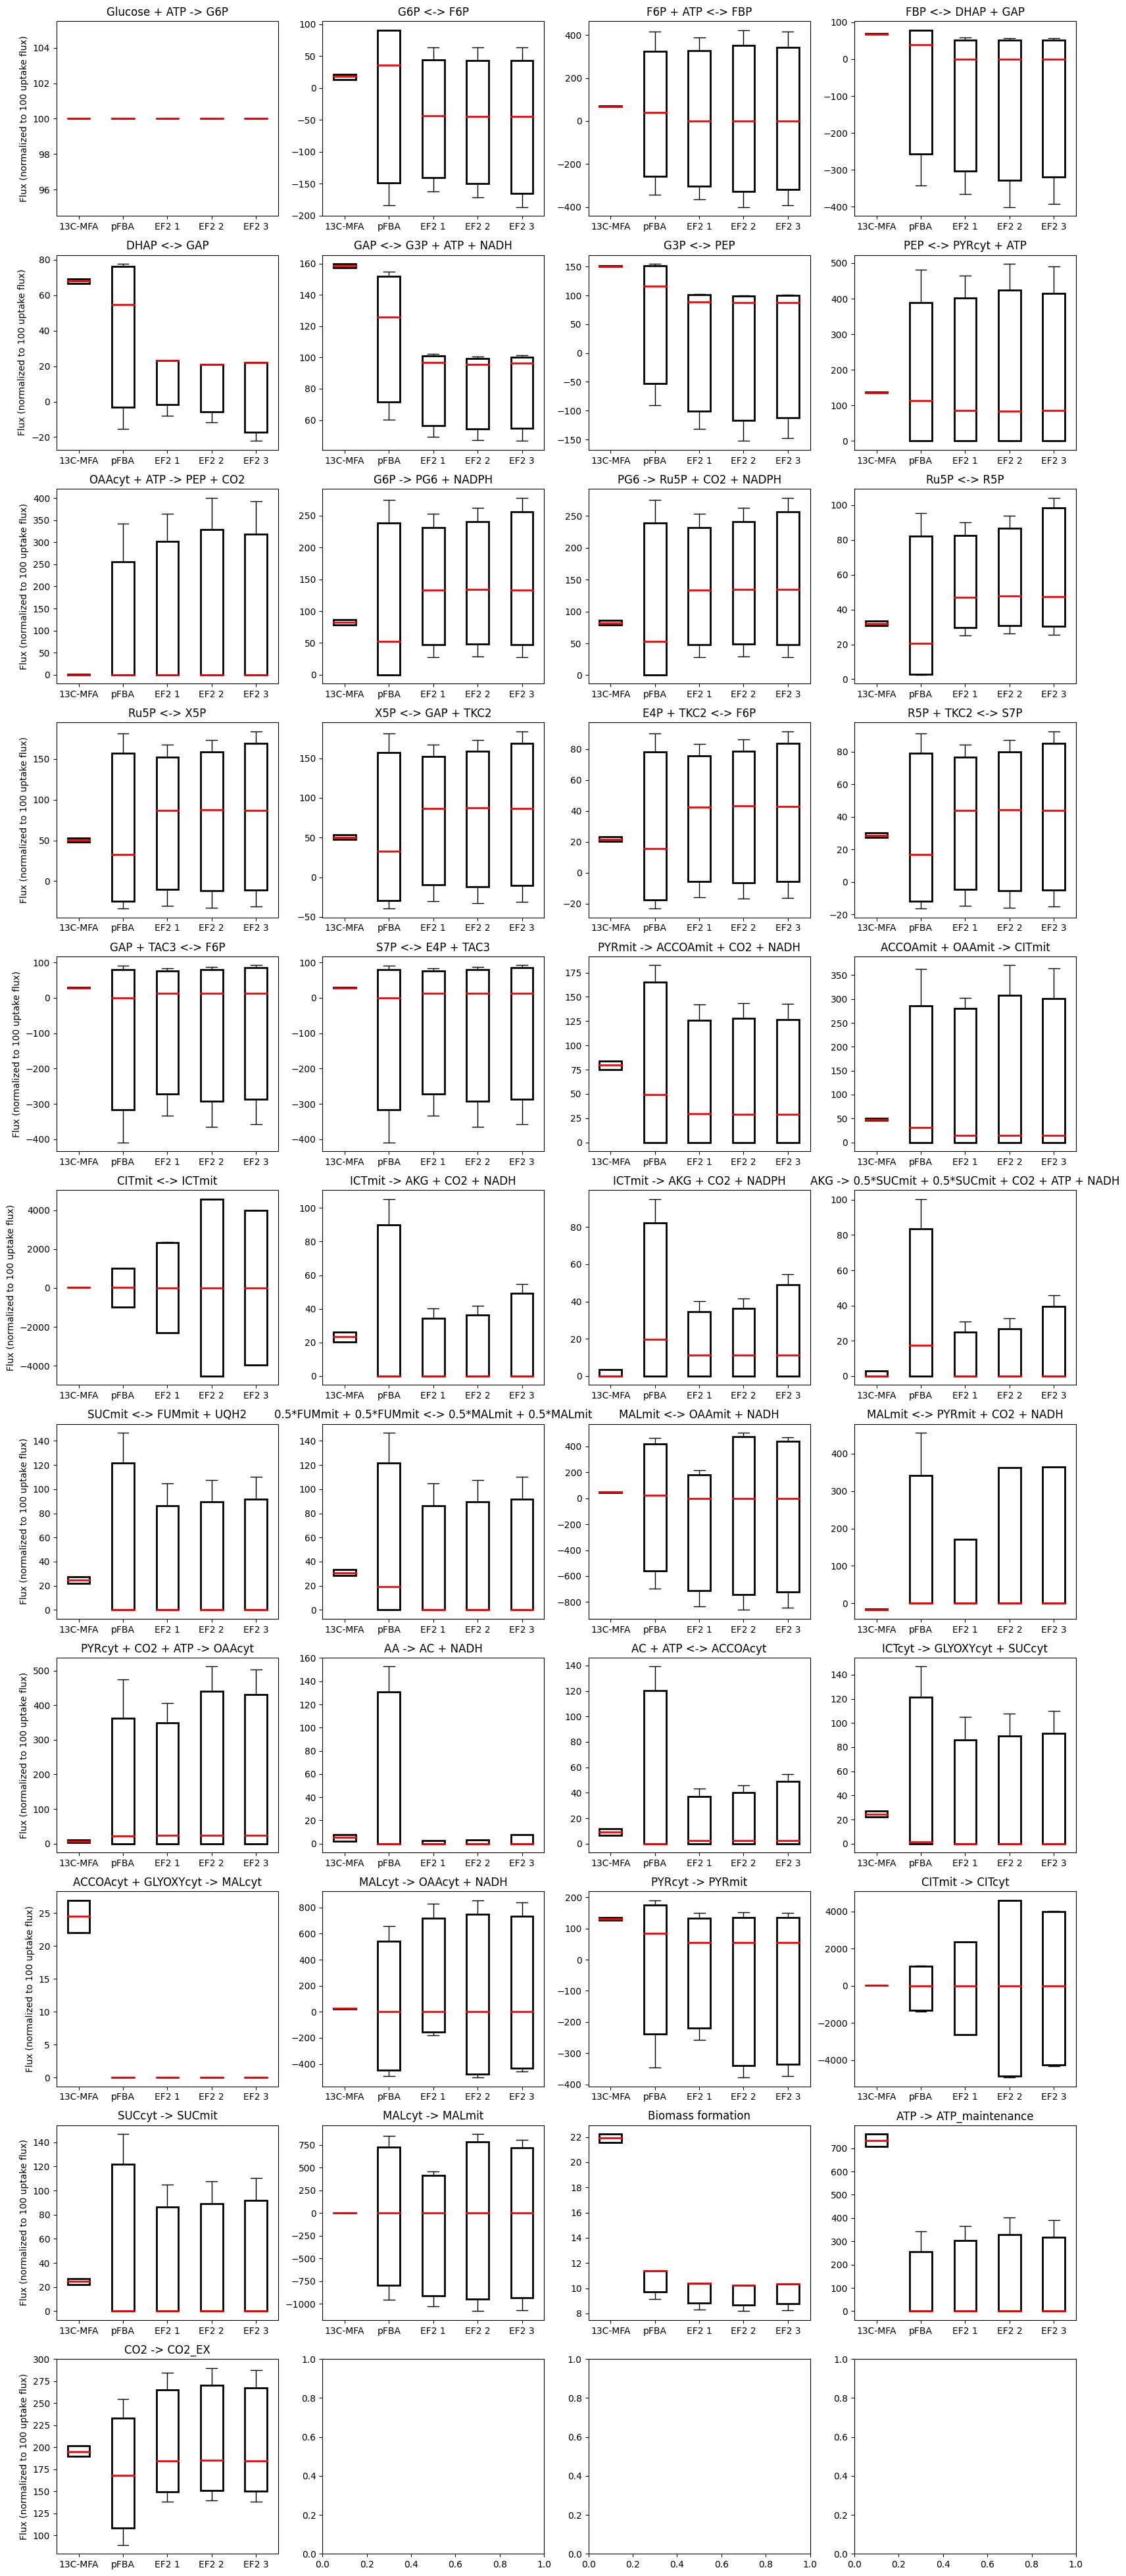

In [35]:
# calculate the biomass percent strings using the box and whisker biomass fractions
box_percent_string = int(box_biomass_fraction * 100)
whisker_percent_string = int(whisker_biomass_fraction * 100)

make_5_boxplot_grid(central_rxn_df, 'glucose', box_percent_string, whisker_percent_string)

# Glycerol

### Define how boxes and whiskers of pFBA and E-Flux2 are defined

In [ ]:
# (Using same values as above)
# box_biomass_fraction = 0.95
# whisker_biomass_fraction = 0.90

### Run pFBA for glycerol

In [ ]:
glycerol_pfba_df = get_pfba_gsm_df(
  model=model, 
  substrate='glycerol', 
  box_biomass_fraction=box_biomass_fraction, 
  whisker_biomass_fraction=whisker_biomass_fraction,
)

glycerol_pfba_df.head()

### Add glycerol pFBA data to the central reaction dataframe

In [ ]:
# add the pFBA data to the central reaction dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glycerol_pfba_df, 'glycerol_pfba_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glycerol_pfba_df, 'glycerol', 'pfba')

central_rxn_df.head()

### Run E-Flux2 for glycerol 1

In [ ]:
glycerol_1_eflux2_df = get_eflux2_gsm_df(model, 'glycerol', glycerol_1_reaction_transcripts, box_biomass_fraction, whisker_biomass_fraction)

glycerol_1_eflux2_df.head()

### Add glycerol 1 E-Flux2 data to the central reaction dataframe

In [ ]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, glycerol_1_eflux2_df, 'glycerol_1')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glycerol_1_eflux2_df, 'glycerol_1_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glycerol_1_eflux2_df, 'glycerol_1', 'eflux2')

central_rxn_df.head()

### Run E-Flux2 for glycerol 2

In [ ]:
glycerol_2_eflux2_df = get_eflux2_gsm_df(model, 'glycerol', glycerol_2_reaction_transcripts, box_biomass_fraction, whisker_biomass_fraction)

glycerol_2_eflux2_df.head()

### Add glycerol 2 E-Flux2 data to the central reaction dataframe

In [ ]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, glycerol_2_eflux2_df, 'glycerol_2')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glycerol_2_eflux2_df, 'glycerol_2_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glycerol_2_eflux2_df, 'glycerol_2', 'eflux2')

central_rxn_df.head()

### Run E-Flux2 for glycerol 3

In [ ]:
glycerol_3_eflux2_df = get_eflux2_gsm_df(model, 'glycerol', glycerol_3_reaction_transcripts, box_biomass_fraction, whisker_biomass_fraction)

glycerol_3_eflux2_df.head()

### Add glycerol 3 E-Flux2 data to the central reaction dataframe

In [ ]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, glycerol_3_eflux2_df, 'glycerol_3')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glycerol_3_eflux2_df, 'glycerol_3_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glycerol_3_eflux2_df, 'glycerol_3', 'eflux2')

central_rxn_df.head()

### Plot glycerol MFA vs pFBA vs E-Flux2 boxplots

In [ ]:
# calculate the biomass percent strings using the box and whisker biomass fractions
box_percent_string = int(box_biomass_fraction * 100)
whisker_percent_string = int(whisker_biomass_fraction * 100)

make_5_boxplot_grid(central_rxn_df, 'glycerol', box_percent_string, whisker_percent_string)

# Oleic Acid

### Define how boxes and whiskers of pFBA and E-Flux2 are defined

In [ ]:
# (Using same values as above)
# box_biomass_fraction = 0.95
# whisker_biomass_fraction = 0.90

### Run pFBA for oleic acid

In [ ]:
oleic_acid_pfba_df,  = get_pfba_gsm_df(
  model=model, 
  substrate='oleic_acid', 
  box_biomass_fraction=box_biomass_fraction, 
  whisker_biomass_fraction=whisker_biomass_fraction,
)

oleic_acid_pfba_df.head()

### Add oleic acid pFBA data to the central reaction dataframe

In [ ]:
# add the pFBA data to the central reaction dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, oleic_acid_pfba_df, 'oleic_acid_pfba_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, oleic_acid_pfba_df, 'oleic_acid', 'pfba')

central_rxn_df.head()

### Run E-Flux2 for oleic acid 1

In [ ]:
oleic_acid_1_eflux2_df = get_eflux2_gsm_df(model, 'oleic_acid', oleic_acid_1_reaction_transcripts, box_biomass_fraction, whisker_biomass_fraction)

oleic_acid_1_eflux2_df.head()

### Add oleic acid 1 E-Flux2 data to the central reaction dataframe

In [ ]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, oleic_acid_1_eflux2_df, 'oleic_acid_1')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, oleic_acid_1_eflux2_df, 'oleic_acid_1_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, oleic_acid_1_eflux2_df, 'oleic_acid_1', 'eflux2')

central_rxn_df.head()

### Run E-Flux2 for oleic acid 2

In [ ]:
oleic_acid_2_eflux2_df = get_eflux2_gsm_df(model, 'oleic_acid', oleic_acid_2_reaction_transcripts, box_biomass_fraction, whisker_biomass_fraction)

oleic_acid_2_eflux2_df.head()

### Add oleic acid 2 E-Flux2 data to the central reaction dataframe

In [ ]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, oleic_acid_2_eflux2_df, 'oleic_acid_2')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, oleic_acid_2_eflux2_df, 'oleic_acid_2_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, oleic_acid_2_eflux2_df, 'oleic_acid_2', 'eflux2')

central_rxn_df.head()

### Run E-Flux2 for oleic acid 3

In [ ]:
oleic_acid_3_eflux2_df = get_eflux2_gsm_df(model, 'oleic_acid', oleic_acid_3_reaction_transcripts, box_biomass_fraction, whisker_biomass_fraction)

oleic_acid_3_eflux2_df.head()

### Add oleic acid 3 E-Flux2 data to the central reaction dataframe

In [ ]:
# add the E-Flux2 data to the central reaction dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, oleic_acid_3_eflux2_df, 'oleic_acid_3')
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, oleic_acid_3_eflux2_df, 'oleic_acid_3_eflux2_flux')
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, oleic_acid_3_eflux2_df, 'oleic_acid_3', 'eflux2')

central_rxn_df.head()

### Plot oleic acid MFA vs pFBA vs E-Flux2 boxplots

In [ ]:
# calculate the biomass percent strings using the box and whisker biomass fractions
box_percent_string = int(box_biomass_fraction * 100)
whisker_percent_string = int(whisker_biomass_fraction * 100)

make_5_boxplot_grid(central_rxn_df, 'oleic_acid', box_percent_string, whisker_percent_string)

# Save Data

### Save central flux data with pFBA data added

In [ ]:
# save the dataframe to a csv file
central_rxn_df.to_csv('../results/central_fluxes/pfba_and_eflux2.csv', index=False, encoding='utf-8-sig')